In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *


In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
j = json.load(open('data/annotations.json'))

In [4]:
j[0]['annotations'][0]

{'class': 'fluke',
 'height': 372.0,
 'type': 'rect',
 'width': 1017.0,
 'x': 14.0,
 'y': 97.0}

In [5]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [6]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

In [7]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2bbox[path2fn(o)]

In [8]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

In [9]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [10]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

In [11]:
data.valid_ds.items

array(['data/train-224/./0dcfd05bf.jpg', 'data/train-224/./fe576c02a.jpg', 'data/train-224/./c30634691.jpg',
       'data/train-224/./f6218e09a.jpg', ..., 'data/train-224/./37910314d.jpg', 'data/train-224/./74996cbcc.jpg',
       'data/train-224/./e36654163.jpg', 'data/train-224/./20601c5bf.jpg'], dtype='<U31')

In [12]:
batch = next(iter(data.valid_dl))

In [13]:
batch[0][0][1]

tensor([[1.9909, 1.9559, 1.9384,  ..., 1.9034, 1.9209, 1.9559],
        [1.8333, 1.8508, 1.9034,  ..., 1.8683, 1.9034, 1.9734],
        [1.6408, 1.7458, 1.8683,  ..., 1.7283, 1.8158, 1.9384],
        ...,
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
       device='cuda:0')

In [14]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fceac0977b8>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fcec4151ae8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7fcecae74f28>)

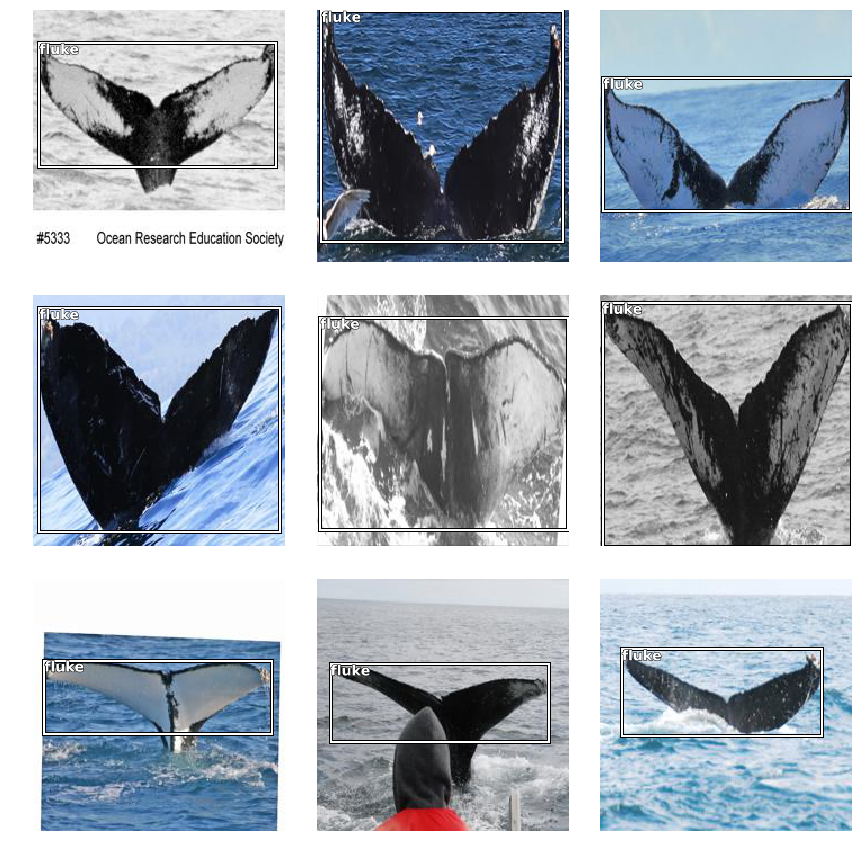

In [15]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [37]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)
def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)


def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

In [30]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [31]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [32]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [33]:
learn.freeze_to(-1)

In [40]:
%time learn.fit_one_cycle(50, 1e-2, div_factor=12, pct_start=0.2)

epoch     train_loss  valid_loss  <lambda>
1         0.047493    0.041606    0.879953  
2         0.047902    0.042850    0.876707  
3         0.048155    0.044079    0.873669  
4         0.048943    0.044569    0.871074  
5         0.050491    0.045784    0.864623  
6         0.052232    0.067060    0.829303  
7         0.053013    0.053843    0.844060  
8         0.054388    0.068444    0.806234  
9         0.056359    0.058264    0.825126  
10        0.058084    0.065787    0.820637  
11        0.059606    0.082026    0.797865  
12        0.062456    0.060457    0.834227  
13        0.063241    0.055259    0.845212  
14        0.063284    0.070368    0.808554  
15        0.063382    0.070531    0.796866  
16        0.064977    0.085711    0.778963  
17        0.064168    0.051945    0.855320  
18        0.063796    0.047955    0.860763  
19        0.061787    0.045395    0.874541  
20        0.060179    0.045466    0.857569  
21        0.058880    0.050267    0.848914  
22        0.

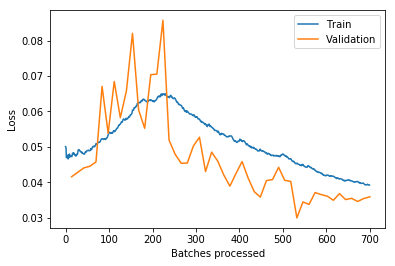

In [41]:
learn.recorder.plot_losses()

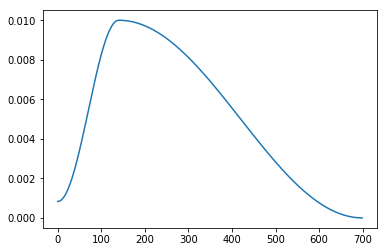

In [42]:
learn.recorder.plot_lr()

In [43]:
learn.unfreeze()

In [44]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [45]:
%time learn.fit_one_cycle(120, lrs)

epoch     train_loss  valid_loss  <lambda>
1         0.040874    0.032106    0.903539  
2         0.039460    0.031851    0.903758  
3         0.039725    0.031356    0.905776  
4         0.039670    0.035343    0.900415  
5         0.039749    0.032359    0.905134  
6         0.039876    0.031911    0.903411  
7         0.039437    0.030362    0.909669  
8         0.039554    0.030954    0.908269  
9         0.038815    0.033299    0.903167  
10        0.039310    0.035901    0.896485  
11        0.039391    0.034591    0.900473  
12        0.038496    0.030975    0.905648  
13        0.038590    0.036016    0.898594  
14        0.038531    0.034670    0.898680  
15        0.038523    0.037115    0.892790  
16        0.039495    0.040063    0.880749  
17        0.039968    0.032999    0.902280  
18        0.039380    0.034370    0.897557  
19        0.039526    0.038306    0.891378  
20        0.038782    0.035246    0.900794  
21        0.038799    0.033994    0.899649  
22        0.

In [46]:
learn.save('fluke_detector')

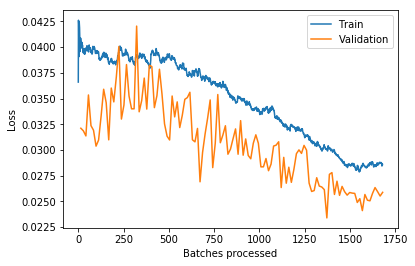

In [47]:
learn.recorder.plot_losses()

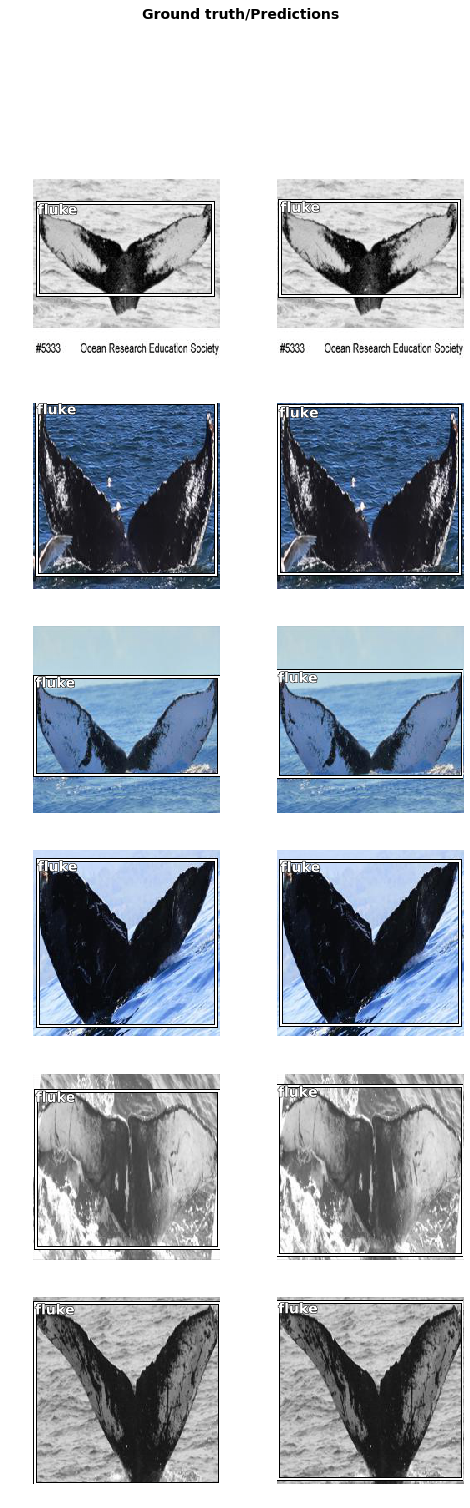

In [48]:
learn.show_results(rows=6)